<a href="https://colab.research.google.com/github/Danr17/MLDLTF_coding/blob/master/Vision/MNIST_Linear_Model_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits to Google training,  Advanced Machine Learning with Tensorflow on GCP

In [1]:
import numpy as np
import shutil
import tensorflow as tf
print(tf.__version__)

1.12.0


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("mnist/data", one_hot=True, reshape=False)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)
(55000, 10)


In [6]:
print(mnist.test.images.shape)
print(mnist.test.labels.shape)

(10000, 28, 28, 1)
(10000, 10)


In [0]:
HEIGHT=28
WIDTH=28
NCLASSES=10

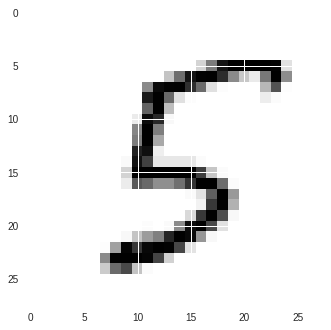

In [10]:
import matplotlib.pyplot as plt
IMGNO=23
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH))

**Define the Linear model low level or using tf.layers API**

In [0]:
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) # flatten
  W = tf.get_vairable("W", [HEIGHT*WIDTH, NCLASSES], initializer=tf.truncated_normal_initilizer(stddev=0.1, seed=1))
  b = tf.get_variable("b", NCLASSES, initializer=tf.zeros_initializer)
  ylogits = tf.matmul(X,W) + b
  return ylogits, NCLASSES

In [0]:
def linear_model(img):
  X=tf.reshape(img,[-1, HEIGHT*WIDTH])
  ylogits = tf.layers.dense(X,NCLASSES,activation = None)
  return ylogits, NCLASSES

Result for Linear: Saving dict for global step 1000: accuracy = 0.9177, global_step = 1000, loss = 0.29642856

**Write Input Functions**

In [0]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image':mnist.train.images},
    y = mnist.train.labels,
    batch_size = 100,
    num_epochs = None,
    shuffle = True,
    queue_capacity = 5000
)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.test.images},
    y=mnist.test.labels,
    batch_size = 100,
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 5000
)

In [0]:
def serving_input_fn():
  inputs = {'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
  features = inputs # no change
  return tf.estimator.export.ServingInputReceiver(features, inputs)

**Write a custom estimator to accomodate Linear, DNN and CNN models**

In [0]:
def image_classifier(features, labels, mode, params):
  ylogits, nclasses = linear_model(features['image'])
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities, 1), tf.uint8)
  
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ylogits, labels=labels))
    evalmetrics ={'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels, 1))}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(), learning_rate=params['learning_rate'], optimizer="Adam")
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
  return tf.estimator. EstimatorSpec(
        mode=mode,
        predictions={"probabbilities": probabilities, "classes": classes},
        loss=loss,
        train_op=train_op,
        eval_metric_ops=evalmetrics,
        export_outputs={"classes": tf.estimator.export.PredictOutput({"probabilities": probabilities, "classes": classes})}
    )

In [0]:
def train_and_evaluate(output_dir, hparams):
  estimator = tf.estimator.Estimator(model_fn = image_classifier, params = hparams, model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn, max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('Servo', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn, steps = None, exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [39]:
OUTDIR = 'mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh

hparams = {'train_steps': 1000, 'learning_rate': 0.01}
train_and_evaluate(OUTDIR, hparams)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist/learned', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f132ef15a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta